In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# from google.colab import userdata
# token = userdata.get('GITHUB_TOKEN')
# user_name = userdata.get('GITHUB_USERNAME')
# mail = userdata.get('GITHUB_MAIL')

# !git config --global user.name "{user_name}"
# !git config --global user.email "{mail}"
# !git clone https://{token}@github.com/azhgh22/Walmart-Recruiting-Store-Sales-Forecasting.git

%cd Walmart-Recruiting-Store-Sales-Forecasting

# from google.colab import userdata
# ! pip install -r ./requirements.txt
# kaggle_json_path = userdata.get('KAGGLE_JSON_PATH')
# ! ./src/data_loader.sh -f {kaggle_json_path}

/content/Walmart-Recruiting-Store-Sales-Forecasting


In [2]:
# **Torch**

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.config import *

stores = pd.read_csv(STORES_PATH)
features = pd.read_csv(FEATURES_PATH)
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

train['Date'] = pd.to_datetime(train.Date)



In [83]:
#  train.groupby(['Dept','Store']).count()[train.groupby(['Dept','Store']).count()['Date']!=143]

In [3]:
from src.processing import split_data
x_train,y_train,x_val,y_val = split_data(train[(train['Dept']==1) & (train['Store']==1)])

In [4]:
## **Data creation**

def create_data_nbeats(x_train:pd.DataFrame,y_train:pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame()

    df = df.reset_index()
    df["Date"] = x_train.Date
    df["Store"] = x_train.Store
    df["Dept"] = x_train.Dept
    # df["IsHoliday"] = x_train.IsHoliday.astype(int)
    df["y"] = y_train.values

    df.rename(columns={"Date": "ds"}, inplace=True)
    df["unique_id"] = df["Store"].astype(str) + "_" + df["Dept"].astype(str)

    df = df[["unique_id", "ds", "y"]].copy()
    df = df.sort_values(by=["ds"])
    # df.reset_index(drop=True, inplace=True)
    return df


In [6]:
!pip show neuralforecast

Name: neuralforecast
Version: 3.0.2
Summary: Time series forecasting suite using deep learning models
Home-page: https://github.com/Nixtla/neuralforecast/
Author: Nixtla
Author-email: business@nixtla.io
License: Apache Software License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: coreforecast, fsspec, numpy, optuna, pandas, pytorch-lightning, ray, torch, utilsforecast
Required-by: 


In [5]:
import torch
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import MSE
import logging

df = create_data_nbeats(x_train,y_train)

model = NBEATS(
    input_size=15,
    h=48,
    max_steps=25 * 104,
    batch_size=64,
    learning_rate=0.001,
    # weight_decay=1e-5,
    # dropout_prob_theta=0.4,
    dropout_prob_theta=0.1,
    stack_types=(['identity', 'trend', 'seasonality']),
    n_blocks = [3,3,3],
    random_seed=42,
    accelerator='gpu',     # <--- Correct: This is an NBEATS argument now
    devices=1,             # <--- Correct: This is an NBEATS argument now
    logger=True,          # <--- Correct: This is an NBEATS argument now
    enable_progress_bar=False,
    enable_model_summary=False,
    optimizer_kwargs={'weight_decay': 1e-20}
)
nf = NeuralForecast(models=[model], freq='W-FRI')
nf.fit(df)

INFO:lightning_fabric.utilities.seed:Seed set to 42


NotImplementedError: dropout

In [151]:
!pip install neuralforecast --upgrade

In [145]:
preds = nf.predict()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [146]:
# preds = nf.predict()

print(preds.shape)
print(x_val.shape)

from src.utils import wmae

real = create_data_nbeats(x_val,y_val)
merged = pd.merge(real, preds, on=['unique_id','ds'],how='left')
# print(merged.shape)
merged.fillna(0,inplace=True)
holidays = x_val['IsHoliday']
wmae(y_val,merged['NBEATS'],holidays)

(48, 3)
(48, 4)


np.float64(3484.612114583333)

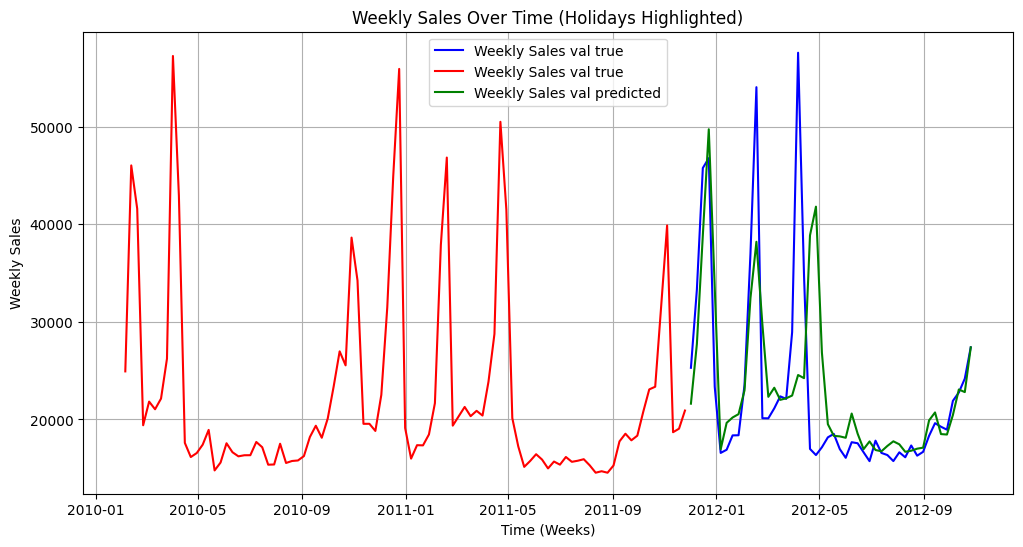

In [129]:
# forecast.predict(x_val)

plt.figure(figsize=(12, 6))
plt.plot(x_val.Date, y_val, label='Weekly Sales val true', color='blue')
plt.plot(x_train.Date, y_train, label='Weekly Sales val true', color='red')
plt.plot(x_val.Date, merged.NBEATS, label='Weekly Sales val predicted', color='green')
# plt.scatter(holidays['Date'], holidays['Weekly_Sales'], color='red', label='Holiday', zorder=5)

plt.title("Weekly Sales Over Time (Holidays Highlighted)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()